In [11]:
import pandas as pd
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
import collections, numpy
import matplotlib.pyplot as plt
import os
print(os.listdir("input"))
pd.__version__

%matplotlib inline

['.gitignore', 'datahack_2018.ipynb', 'leaderboard.md', 'LogoDark.png', 'README.md', 'requirements.txt', 'test_usage_data.csv', 'test_users_data.csv', 'train_usage_data.csv', 'train_users_data.csv']


In [12]:
#formatting data

In [13]:
train_meta_users = pd.read_csv('input/train_users_data.csv')
train_meta_users.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
train_meta_users['initial_device'] = train_meta_users['initial_device'].apply(lambda x:x.replace('UIDeviceKind', ''))
train_meta_users["installation_date"] = pd.to_datetime(train_meta_users['installation_date'], infer_datetime_format=True)
train_meta_users["subscripiton_date"] = pd.to_datetime(train_meta_users['subscripiton_date'], infer_datetime_format=True)
train_meta_users['delta_date'] = (train_meta_users["subscripiton_date"] - train_meta_users["installation_date"]).apply(lambda x: x.days if x.seconds//3600 < 12 else x.days + 1)
train_meta_users.set_index('id', inplace=True)
train_meta_users.head(5)

,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned,delta_date
id,,,,,,,,,
100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,1.9.1,11.2.5,IPhoneX,NaN,0,258
100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,1.7.5,11.2.1,IPhoneX,136.0,0,467
100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,1.6,10.3.3,IPhone6S,70.0,0,416
100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,1.9.5,11.2.6,IPhone5S,NaN,0,115
100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,1.9.5,11.2.6,IPhone8,9.0,1,121


In [24]:
train_usage_users = pd.read_csv('input/train_usage_data.csv')
train_usage_users.set_index('id', inplace=True)
train_usage_users.head(5)

,feature_name,usage_duration,end_use_date,accepted
id,,,,
30000429392689,Relight,5.659,2018-04-10 11:18:16,False
440000407817536,Crop,0.984,2018-04-06 16:44:19,False
540000265662400,Crop,1.583,2018-04-21 18:46:24,False
220000444951653,Vignette,4.668,2018-04-30 14:11:22,False
220000444725338,Retouch,185.154,2018-04-29 23:37:34,False


In [36]:
#merge user meta info 

In [41]:
joined_df = train_usage_users.join(train_meta_users, on='index')

In [43]:
joined_df

#churned can only be 1 if days until churned is < 29 

,feature_name,usage_duration,end_use_date,accepted,index,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned,delta_date
id,,,,,,,,,,,,,,
30000429392689,Relight,5.659,2018-04-10 11:18:16,False,30000429392689,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,IPhoneX,NaN,0,41
440000407817536,Crop,0.984,2018-04-06 16:44:19,False,440000407817536,2017-07-21 20:04:15,2018-04-05 22:39:32,United Kingdom,1.9.6,11.2.5,IPhoneX,NaN,0,258
540000265662400,Crop,1.583,2018-04-21 18:46:24,False,540000265662400,2018-04-21 02:01:23,2018-04-21 02:14:14,United States,1.9.6,11.2,IPhone8,NaN,0,0
220000444951653,Vignette,4.668,2018-04-30 14:11:22,False,220000444951653,2018-04-30 12:45:44,2018-04-30 12:57:44,Australia,1.9.6,11.2.5,IPhone7Plus,NaN,0,0
220000444725338,Retouch,185.154,2018-04-29 23:37:34,False,220000444725338,2018-04-29 21:14:23,2018-04-29 22:07:56,United States,1.9.6,11.2.6,IPhone6Plus,31.0,0,0
200000462368481,Touch Up,7.498,2018-04-08 03:01:13,False,200000462368481,2018-04-08 01:18:18,2018-04-08 01:35:38,United States,1.9.6,11.2.6,IPhone7,NaN,0,0
240000452339877,Adjust,22.099,2018-04-08 15:46:37,False,240000452339877,2018-02-15 03:08:55,2018-04-08 15:27:28,United States,1.9.2,11.2.5,IPhone7,29.0,0,53
400000407094422,Filters,14.960,2018-04-13 02:10:30,False,400000407094422,2018-02-24 02:46:07,2018-04-12 20:45:59,United States,1.9.3,11.2.6,IPhoneX,NaN,0,48
250000376716144,Filters,6.387,2018-04-16 15:02:18,False,250000376716144,2018-04-16 14:44:57,2018-04-16 14:51:38,Denmark,1.9.6,11.2.6,IPhoneX,14.0,1,0


In [44]:
# Let's create a table with statistic summaries: rows correspond to users; columns to various statistics:

In [45]:
train_usage_users['index'] = train_usage_users.index

In [46]:
train_usage_users.index

Int64Index([ 30000429392689, 440000407817536, 540000265662400, 220000444951653,
            220000444725338, 200000462368481, 240000452339877, 400000407094422,
            250000376716144, 300000298551434,
            ...
            440000415373230, 110000406550242, 440000415373230, 120000444338280,
             70000452255540,  70000451153452, 260000429897645, 440000415373230,
            310000288984934, 420000380696664],
           dtype='int64', name='id', length=263814)

In [349]:
pd.pivot_table(train_usage_users[['feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0).head(20)

feature_name,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette
id,,,,,,,,,,,,,,,,,
20000443246052,1,0,14,2,1,1,0,0,17,6,0,2,3,5,10,3,25
20000443252617,2,2,0,7,0,0,0,0,16,1,0,10,2,0,4,3,14
20000443310150,2,0,0,9,0,3,1,0,3,1,0,3,0,0,6,0,3
20000443367561,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20000443405819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
20000443434193,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3
20000443469779,12,7,7,2,0,6,4,1,21,4,0,0,4,7,7,7,11
20000443895994,0,0,2,0,1,0,2,0,27,1,0,11,0,0,3,7,11
20000444138744,1,0,0,0,0,0,1,1,4,0,0,1,0,0,0,3,9


In [48]:
users_usage_summaries = pd.pivot_table(train_usage_users[['feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)

In [49]:
# Let's add the mean of 'accepted' for each user:

In [52]:
accepted_rate = train_usage_users.groupby(['id'])['accepted'].mean().to_frame()
churned = joined_df.groupby(['id'])['churned'].mean().to_frame()
train_meta_users_delta_date = train_meta_users.groupby(['id'])['delta_date'].sum().to_frame()
data_res = users_usage_summaries.join(accepted_rate, how='left').join(churned, how='left').join(train_meta_users_delta_date, how='left')

In [53]:
features = data_res.drop(["churned"], axis=1).columns

In [54]:
features

Index(['Adjust', 'Backdrop', 'Crop', 'Darkroom', 'Defocus', 'Eyes', 'Face',
       'Filters', 'Light FX', 'Paint', 'Patch', 'Prism', 'Relight', 'Reshape',
       'Retouch', 'Touch Up', 'Vignette', 'accepted', 'delta_date'],
      dtype='object')

In [293]:
#time features

In [335]:
train_usage_users["end_use_date"] = pd.to_datetime(train_usage_users['end_use_date'], infer_datetime_format=True)

In [338]:
train_usage_users.groupby(train_usage_users["end_use_date"].dt.month).count()

,feature_name,usage_duration,end_use_date,accepted
end_use_date,,,,
4,249737,249737,249737,249737
5,14077,14077,14077,14077


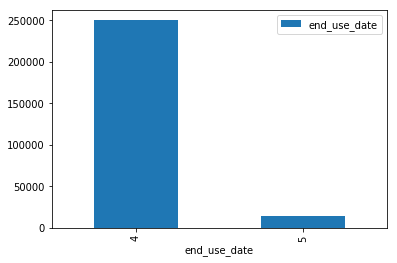

In [340]:
train_usage_users.groupby(train_usage_users["end_use_date"].dt.month).count().plot(y = ['end_use_date'], kind="bar")

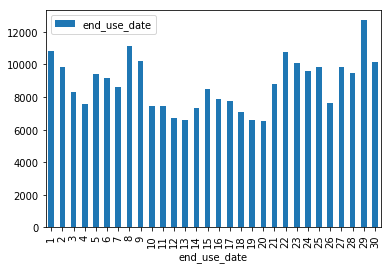

In [342]:
train_usage_users.groupby(train_usage_users["end_use_date"].dt.day).count().plot(y = ['end_use_date'], kind="bar")

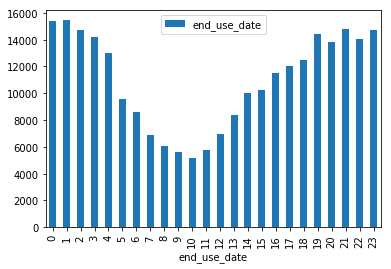

In [343]:
train_usage_users.groupby(train_usage_users["end_use_date"].dt.hour).count().plot(y = ['end_use_date'], kind="bar")

In [345]:
#todo: convert each country to it's appropriate time (it's currently UTC) and see if night / day should be a feature

In [351]:
#todo: add time dependecy features
#todo: add feature of time of day/night of user's usage 

# Classifications 

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(data_res.drop(columns=['churned']), data_res.churned, test_size=0.20, random_state=42)

In [93]:
# Logistic Regression 

In [94]:
from sklearn.linear_model  import LogisticRegression

In [95]:
clfLR = LogisticRegression(random_state=666, solver='lbfgs', multi_class='multinomial', n_jobs = 16)

In [96]:
clfLR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=16, penalty='l2', random_state=666, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [97]:
clfLR_y_pred = clfLR.predict(X_test)

In [98]:
confusion_matrix(y_test, clfLR_y_pred)

array([[1244,    0],
       [ 156,    0]], dtype=int64)

In [101]:
precision_recall_fscore_support(y_dfNoTime_test, clfLR_y_pred, average='macro')

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.4442857142857143, 0.5, 0.47049924357034795, None)

In [102]:
sk.metrics.f1_score(y_dfNoTime_test, clfLR_y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [ ]:
#doesn't seem to help much, moving on to other classifers ...

In [284]:
def DataPreprocessing(trainUsersPath, trainUsagePath,train):
    
    #formatting data
    train_meta_users = pd.read_csv(trainUsersPath)
    train_meta_users.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
    train_meta_users['initial_device'] = train_meta_users['initial_device'].apply(lambda x:x.replace('UIDeviceKind', ''))
    train_meta_users["installation_date"] = pd.to_datetime(train_meta_users['installation_date'], infer_datetime_format=True)
    train_meta_users["subscripiton_date"] = pd.to_datetime(train_meta_users['subscripiton_date'], infer_datetime_format=True)
    train_meta_users['delta_date'] = (train_meta_users["subscripiton_date"] - train_meta_users["installation_date"]).apply(lambda x: x.days if x.seconds//3600 < 12 else x.days + 1)
    train_meta_users.set_index('id', inplace=True)
    
    train_usage_users = pd.read_csv(trainUsagePath)
    train_usage_users.set_index('id', inplace=True)
    
    #merge user meta info 
    joined_df = train_usage_users.join(train_meta_users, on='id')
    #joined_df = train_usage_users.join(train_meta_users, on='index')
    
    # Let's create a table with statistic summaries: rows correspond to users; columns to various statistics:
    train_usage_users['index'] = train_usage_users.index
    pd.pivot_table(train_usage_users[['feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)
    users_usage_summaries = pd.pivot_table(train_usage_users[['feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)
    
    # Let's add the mean of 'accepted' for each user:
    accepted_rate = train_usage_users.groupby(['id'])['accepted'].mean().to_frame()
    
    if (train):
        churned = joined_df.groupby(['id'])['churned'].mean().to_frame()
        train_meta_users_delta_date = train_meta_users.groupby(['id'])['delta_date'].sum().to_frame()
        data_res = users_usage_summaries.join(accepted_rate, how='left').join(churned, how='left').join(train_meta_users_delta_date, how='left')
    else:
        train_meta_users_delta_date = train_meta_users.groupby(['id'])['delta_date'].sum().to_frame()
        data_res = users_usage_summaries.join(accepted_rate, how='left').join(train_meta_users_delta_date, how='left')
        
    return data_res

In [285]:
def Train(title, modelFit, modelPredict, y_test): 
    
    print(title+'\n')
    
    modelFit
    yPreds = modelPredict
    
    print("Prediction count:",str(collections.Counter(yPreds)))
    print("Confusion matrix:", str(confusion_matrix(y_test, yPreds)))
    print("Precision,recall,fscore,support:", str(precision_recall_fscore_support(y_test, yPreds, average='macro')))
    print("F1 score: ", str(sk.metrics.f1_score(y_test, yPreds, labels=None, pos_label=1, average='binary', sample_weight=None)))

In [286]:
def Predict(title,modelPredict):
    print(title+'\n')
    yPreds = modelPredict
    print("Prediction count:",str(collections.Counter(yPreds)))
    return yPreds

In [287]:
def ExportForLeaderboard(xtest,ytest):
    data = {'id': xtest.index, 'churned': ytest}
    
    path = './'
    teamname = 'huji hackers'
    out_name = path + teamname + '_submission.csv'
    
    pd.DataFrame.from_dict(data).to_csv(out_name, sep='\t')

In [288]:
#preparing data 

trainUsersPath = 'input/train_users_data.csv'
trainUsagePath = 'input/train_usage_data.csv'

train_data_res = DataPreprocessing(trainUsersPath, trainUsagePath, train = True)
xtrain,xtest,ytrain,ytest = train_test_split(train_data_res.drop(columns=['churned']), train_data_res.churned, test_size=0.20, random_state=42)

In [289]:
testUsersPath = 'input/test_users_data.csv'
testUsagePath = 'input/test_usage_data.csv'

x_crossvalidation = DataPreprocessing(testUsersPath, testUsagePath, train = False)

In [290]:
# naive bayes

clfNB = GaussianNB()

Train(
    'Naive bayes train',
    clfNB.fit(X_train, y_train),
    clfNB.predict(X_test),
    y_test
)

Naive bayes train

Prediction count: Counter({0: 1304, 1: 96})
Confusion matrix: [[1155   89]
 [ 149    7]]
Precision,recall,fscore,support: (0.47932643149284254, 0.4866641932558331, 0.4810744810744811, None)
F1 score:  0.05555555555555556


In [291]:
# naive bayes
clfLR_y_pred = Predict('Naive bayes train',clfNB.predict(x_crossvalidation))

Naive bayes train

Prediction count: Counter({0: 1586, 1: 146})


In [292]:
ExportForLeaderboard(x_crossvalidation,clfLR_y_pred)

In [ ]:
#maybe svm will help us out

In [294]:
from sklearn.svm import SVC

In [295]:
#svm

clfSVC = SVC(gamma='auto', kernel='rbf', probability=True, cache_size = 5000)


In [298]:
Train(
    'SVM',
    clfSVC.fit(X_train, y_train),
    clfSVC.predict(X_test),
    y_test
)

SVM

Prediction count: Counter({0: 1400})
Confusion matrix: [[1244    0]
 [ 156    0]]
Precision,recall,fscore,support: (0.4442857142857143, 0.5, 0.47049924357034795, None)
F1 score:  0.0


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [297]:
# svm is not gonna help us

In [324]:
#knn
from sklearn.neighbors import KNeighborsClassifier

In [325]:
clKnn = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
Train(
    'Knn n=5',
    clKnn.fit(X_train, y_train),
    clKnn.predict(X_test),
    y_test
)

Knn n=5

Prediction count: Counter({0: 1389, 1: 11})
Confusion matrix: [[1233   11]
 [ 156    0]]
Precision,recall,fscore,support: (0.44384449244060475, 0.49557877813504825, 0.46828712495252567, None)
F1 score:  0.0


In [327]:
clKnn = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
Train(
    'Knn n=1',
    clKnn.fit(X_train, y_train),
    clKnn.predict(X_test),
    y_test
)

Knn n=1

Prediction count: Counter({0: 1245, 1: 155})
Confusion matrix: [[1097  147]
 [ 148    8]]
Precision,recall,fscore,support: (0.4663687006088872, 0.46655742435485204, 0.46646272538074285, None)
F1 score:  0.05144694533762058
